# Human Activity Recognition — Course Project

Authors: girdauskaite + partner

Notebook skeleton to run the full project: data loading, cleaning, EDA, baseline models, required models (RandomForest, XGBoost), additional methods (CatBoost, k-NN), hyperparameter tuning, ablation experiments, and interpretation (SHAP).

Run cells sequentially. Edit paths and parameters where noted.

## 0) Environment / Install packages (run once)

If you are running in a clean environment, run the following cell to install missing packages. In many hosted environments (Colab, Kaggle) some packages are preinstalled.

In [21]:
# !pip install xgboost lightgbm catboost shap tensorflow scikit-learn seaborn matplotlib
# Uncomment the above line and run if packages are missing in your env.

## 1) Imports

In [22]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb

try:
    from catboost import CatBoostClassifier
except Exception:
    CatBoostClassifier = None

import warnings
warnings.filterwarnings('ignore')

print('imports done')

imports done


## 2) Config / Paths / Label mapping
Update paths if your CSVs are in a different location.

In [23]:
# Paths
TRAIN_CSV = 'data/activity_train.csv'  # change if needed
TEST_CSV = 'data/activity_test.csv'    # if provided; may not exist

# Label mapping based on assignment (confirm with instructor files if different)
label_map = {
    1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS',
    4:'SITTING', 5:'STANDING', 6:'LAYING',
    7:'STAND_TO_SIT', 8:'SIT_TO_STAND', 9:'SIT_TO_LIE',
    10:'LIE_TO_SIT', 11:'STAND_TO_LIE', 12:'LIE_TO_STAND'
}

RANDOM_STATE = 42
print('config set')

config set


## 3) Load data (train CSV)
Quick sanity checks: shape, columns, head.

In [24]:
df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)

print('train shape:', df_train.shape)
print('test shape: ', df_test.shape)

# quick sanity: columns must match (except maybe target column)
train_cols = list(df_train.columns)
test_cols = list(df_test.columns)
print('train cols count:', len(train_cols), 'test cols count:', len(test_cols))

# If test has activity column name different or missing, handle below
print('train columns sample:', train_cols[:10])
print('test columns sample :', test_cols[:10])
print('shape:', df_train.shape)
display(df_train.columns[:120])
df_train.head(3)

train shape: (7767, 562)
test shape:  (3162, 562)
train cols count: 562 test cols count: 562
train columns sample: ['tBodyAcc_Mean_1', 'tBodyAcc_Mean_2', 'tBodyAcc_Mean_3', 'tBodyAcc_STD_1', 'tBodyAcc_STD_2', 'tBodyAcc_STD_3', 'tBodyAcc_Mad_1', 'tBodyAcc_Mad_2', 'tBodyAcc_Mad_3', 'tBodyAcc_Max_1']
test columns sample : ['tBodyAcc_Mean_1', 'tBodyAcc_Mean_2', 'tBodyAcc_Mean_3', 'tBodyAcc_STD_1', 'tBodyAcc_STD_2', 'tBodyAcc_STD_3', 'tBodyAcc_Mad_1', 'tBodyAcc_Mad_2', 'tBodyAcc_Mad_3', 'tBodyAcc_Max_1']
shape: (7767, 562)


Index(['tBodyAcc_Mean_1', 'tBodyAcc_Mean_2', 'tBodyAcc_Mean_3',
       'tBodyAcc_STD_1', 'tBodyAcc_STD_2', 'tBodyAcc_STD_3', 'tBodyAcc_Mad_1',
       'tBodyAcc_Mad_2', 'tBodyAcc_Mad_3', 'tBodyAcc_Max_1',
       ...
       'tBodyAccJerk_ARCoeff_6', 'tBodyAccJerk_ARCoeff_7',
       'tBodyAccJerk_ARCoeff_8', 'tBodyAccJerk_ARCoeff_9',
       'tBodyAccJerk_ARCoeff_10', 'tBodyAccJerk_ARCoeff_11',
       'tBodyAccJerk_ARCoeff_12', 'tBodyAccJerk_Correlation_1',
       'tBodyAccJerk_Correlation_2', 'tBodyAccJerk_Correlation_3'],
      dtype='object', length=120)

,tBodyAcc_Mean_1,tBodyAcc_Mean_2,tBodyAcc_Mean_3,tBodyAcc_STD_1,tBodyAcc_STD_2,tBodyAcc_STD_3,tBodyAcc_Mad_1,tBodyAcc_Mad_2,tBodyAcc_Mad_3,tBodyAcc_Max_1,...,fBodyGyroJerkMag_Skewness_1,fBodyGyroJerkMag_Kurtosis_1,tBodyAcc_AngleWRTGravity_1,tBodyAccJerk_AngleWRTGravity_1,tBodyGyro_AngleWRTGravity_1,tBodyGyroJerk_AngleWRTGravity_1,tXAxisAcc_AngleWRTGravity_1,tYAxisAcc_AngleWRTGravity_1,tZAxisAcc_AngleWRTGravity_1,activity
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.314848,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,5
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,5
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,-0.404427,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,5


### 3.1 Check for duplicate column names / typos
We noticed some columns like `tBodyAcc_ropy` or duplicates in header — inspect duplicates and rename or deduplicate as needed.

In [25]:
# list duplicated column names
cols = pd.Series(df_train.columns)
dups = cols[cols.duplicated()].unique()
print('duplicates:', dups)

if len(dups) > 0:
    for d in dups:
        print('\n---', d)
        print(df_train.loc[:, df_train.columns == d].iloc[:2, :5])

duplicates: []


If duplicates are harmless copies, you can drop identical columns; if they correspond to distinct features with slightly different names (typo), rename them to unique names. Example renaming is shown below.

In [26]:
# Example: rename a mis-typed column if present (edit names as required)
rename_map = {}
# rename_map['tBodyAcc_ropy_1.1'] = 'tBodyAcc_ropy_1_copy'   # example
if rename_map:
    df_train.rename(columns=rename_map, inplace=True)
    print('renamed columns')
else:
    print('no renames applied')

no renames applied


## 4) Quick target check and mapping

In [27]:
if 'activity' not in df_train.columns:
    raise ValueError('No `activity` column found in CSV — check your CSV')

print(df_train['activity'].nunique(), 'unique labels')
print(df_train['activity'].value_counts().sort_index())

df_train['activity_name'] = df_train['activity'].map(label_map)
display(df_train['activity_name'].value_counts())

12 unique labels
activity
1     1226
2     1073
3      987
4     1293
5     1423
6     1413
7       47
8       23
9       75
10      60
11      90
12      57
Name: count, dtype: int64


activity_name
STANDING              1423
LAYING                1413
SITTING               1293
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     987
STAND_TO_LIE            90
SIT_TO_LIE              75
LIE_TO_SIT              60
LIE_TO_STAND            57
STAND_TO_SIT            47
SIT_TO_STAND            23
Name: count, dtype: int64

## 5) Basic EDA: class balance, some feature distributions, correlation heatmap

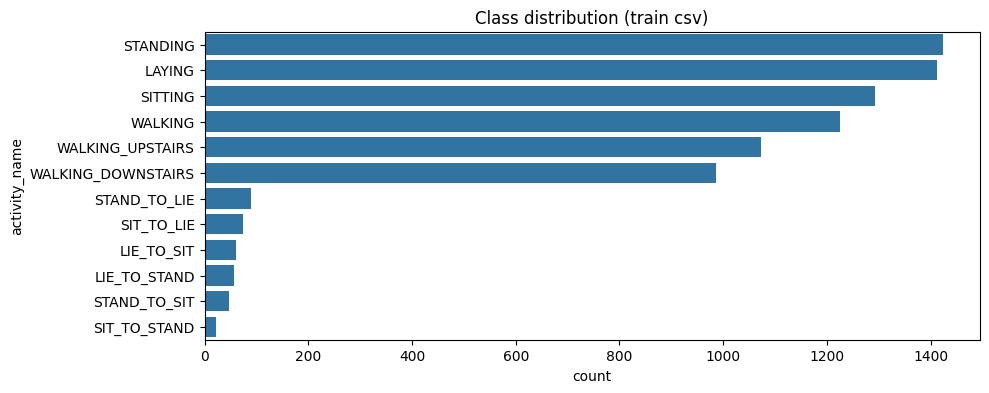

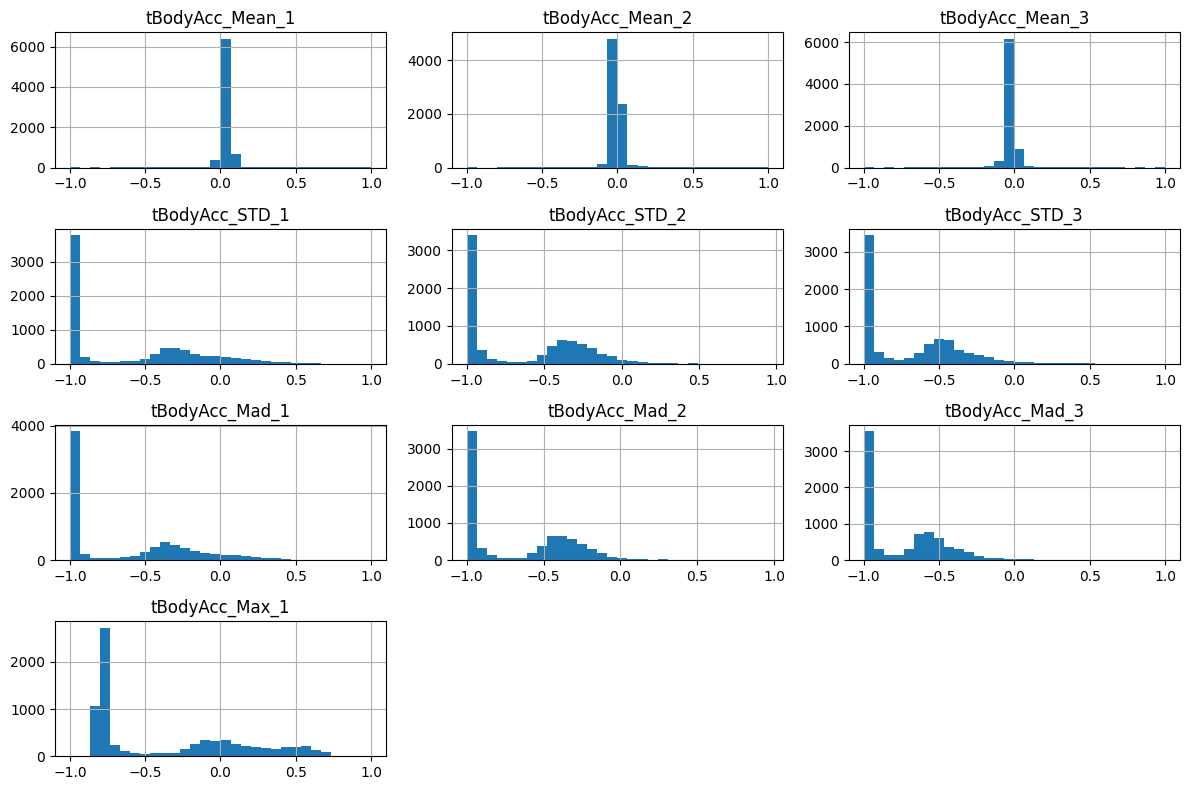

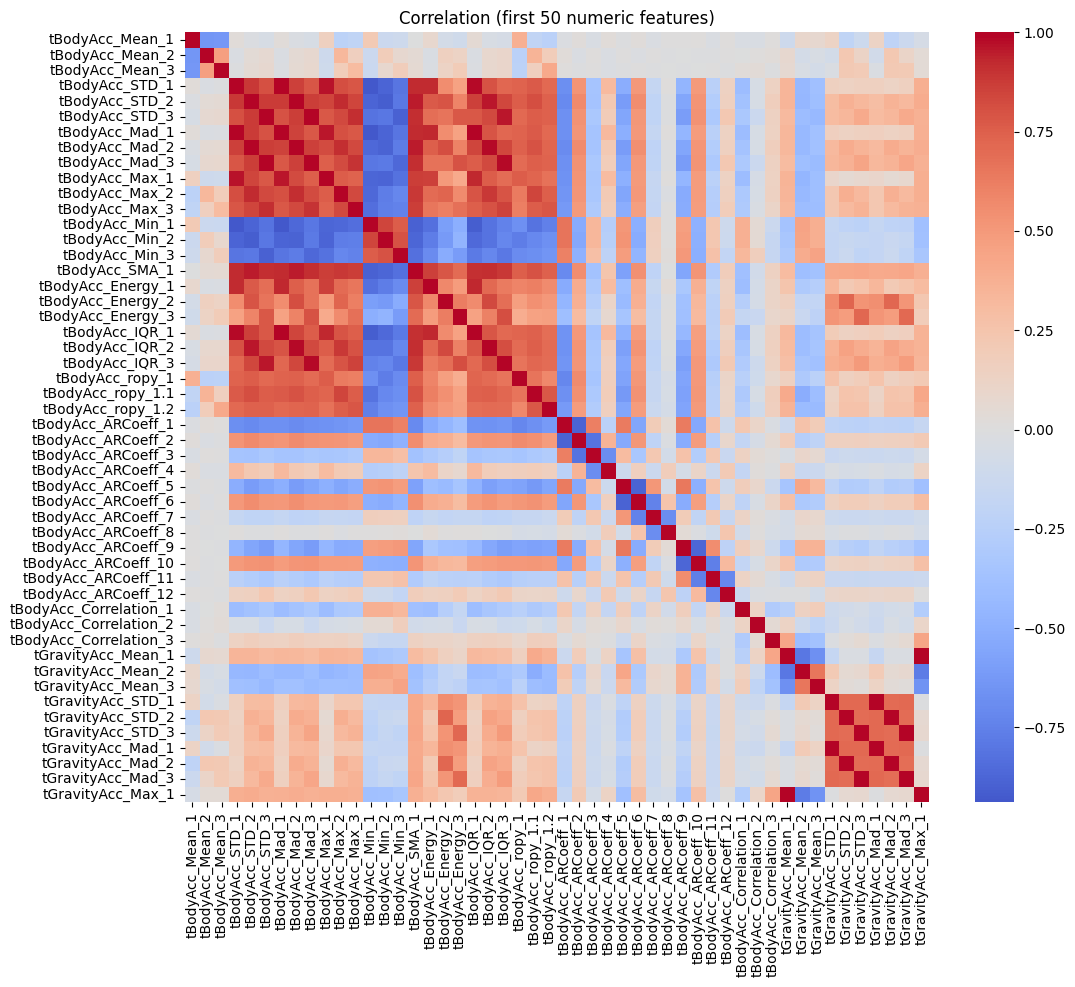

In [28]:
plt.figure(figsize=(10,4))
sns.countplot(y='activity_name', data=df_train, order=df_train['activity_name'].value_counts().index)
plt.title('Class distribution (train csv)')
plt.show()

# display distribution for a few example features
sample_features = list(df_train.columns[:10])
df_train[sample_features].hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

# correlation heatmap for the first 50 numeric features (visual check)
numeric = df_train.select_dtypes(include=[np.number]).columns.tolist()
corr_cols = numeric[:50]
plt.figure(figsize=(12,10))
sns.heatmap(df_train[corr_cols].corr(), cmap='coolwarm', center=0)
plt.title('Correlation (first 50 numeric features)')
plt.show()

## 6) Preprocessing: prepare X, y and train/test split
If you have an official test CSV, load it. Otherwise create a stratified train/test split (70/30 as assignment suggests).

In [29]:
# Features: drop target and name columns
X = df_train.drop(columns=['activity', 'activity_name'])
y = df_train['activity']

print('X shape', X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)

print('train shape', X_train.shape, 'test shape', X_test.shape)


X shape (7767, 561)
train shape (5436, 561) test shape (2331, 561)


### 6.1 Check for NaNs / constant columns

In [30]:
na_cols = X_train.columns[X_train.isna().any()].tolist()
print('columns with NaN:', na_cols)

# drop constant columns
nunique = X_train.nunique()
const_cols = nunique[nunique <= 1].index.tolist()
print('constant columns:', const_cols)

if const_cols:
    X_train.drop(columns=const_cols, inplace=True)
    X_test.drop(columns=const_cols, inplace=True)
    print('dropped constant cols')

print('final feature count:', X_train.shape[1])

columns with NaN: []
constant columns: []
final feature count: 561


## 7) Simple baseline models
Train a Dummy baseline, LogisticRegression and KNN to get baseline scores quickly.

--- Dummy (most frequent)
Accuracy: 0.1831831831831832
Macro F1: 0.025803722504230117
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       368
           2       0.00      0.00      0.00       322
           3       0.00      0.00      0.00       296
           4       0.00      0.00      0.00       388
           5       0.18      1.00      0.31       427
           6       0.00      0.00      0.00       424
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00        23
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00        27
          12       0.00      0.00      0.00        17

    accuracy                           0.18      2331
   macro avg       0.02      0.08      0.03      2331
weighted avg       0.03      0.18      0.06      2331



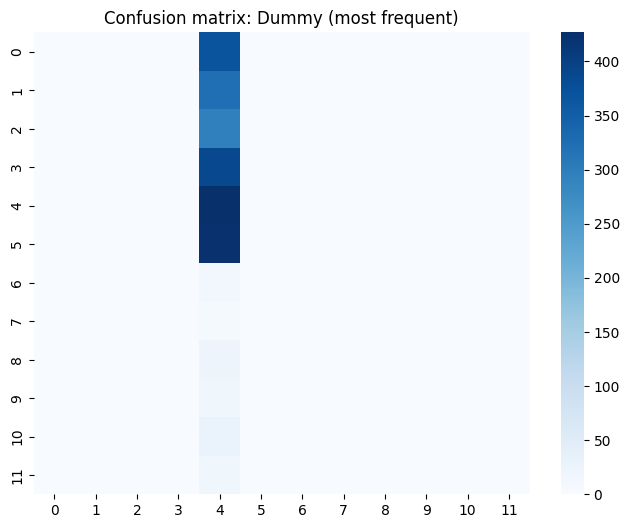

--- LogisticRegression
Accuracy: 0.9708279708279708
Macro F1: 0.8725984707138085
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       368
           2       1.00      1.00      1.00       322
           3       1.00      1.00      1.00       296
           4       0.95      0.95      0.95       388
           5       0.96      0.95      0.96       427
           6       1.00      0.99      0.99       424
           7       0.92      0.79      0.85        14
           8       0.86      0.86      0.86         7
           9       0.69      0.78      0.73        23
          10       0.71      0.67      0.69        18
          11       0.75      0.78      0.76        27
          12       0.62      0.76      0.68        17

    accuracy                           0.97      2331
   macro avg       0.87      0.88      0.87      2331
weighted avg       0.97      0.97      0.97      2331



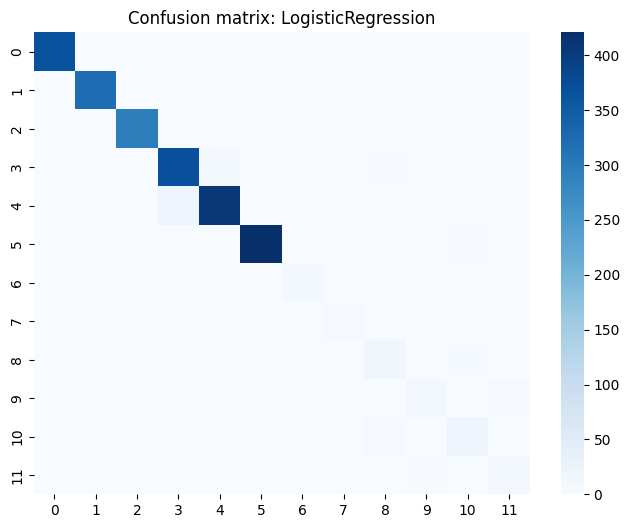

--- KNN (k=5)
Accuracy: 0.9528099528099528
Macro F1: 0.8560408481966603
              precision    recall  f1-score   support

           1       0.99      1.00      0.99       368
           2       0.97      0.99      0.98       322
           3       0.99      0.99      0.99       296
           4       0.95      0.87      0.91       388
           5       0.90      0.96      0.93       427
           6       0.99      0.99      0.99       424
           7       0.64      0.64      0.64        14
           8       1.00      0.86      0.92         7
           9       0.78      0.78      0.78        23
          10       0.70      0.89      0.78        18
          11       0.78      0.52      0.62        27
          12       0.85      0.65      0.73        17

    accuracy                           0.95      2331
   macro avg       0.88      0.84      0.86      2331
weighted avg       0.95      0.95      0.95      2331



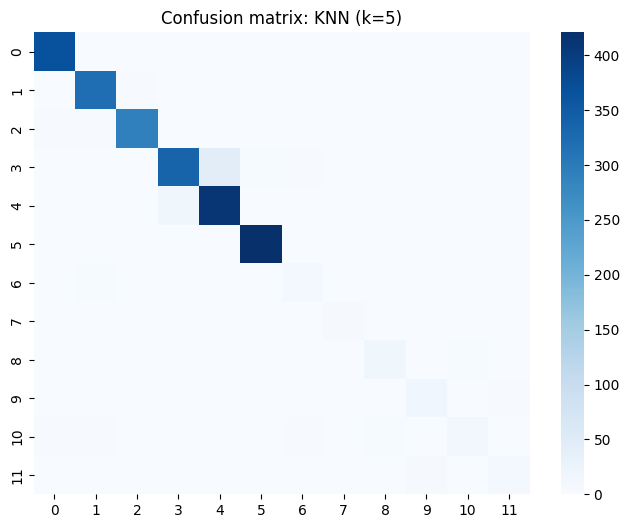

In [31]:
def eval_model(model, X_tr, X_te, y_tr, y_te, name='model'):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    print('---', name)
    print('Accuracy:', accuracy_score(y_te, y_pred))
    print('Macro F1:', f1_score(y_te, y_pred, average='macro'))
    print(classification_report(y_te, y_pred, zero_division=0))
    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.title(f'Confusion matrix: {name}')
    plt.show()

# Dummy baseline
dummy = DummyClassifier(strategy='most_frequent')
eval_model(dummy, X_train, X_test, y_train, y_test, name='Dummy (most frequent)')

# Logistic with scaling
pipe_lr = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])
eval_model(pipe_lr, X_train, X_test, y_train, y_test, name='LogisticRegression')

# KNN quick (baseline)
pipe_knn = Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=5))])
eval_model(pipe_knn, X_train, X_test, y_train, y_test, name='KNN (k=5)')

## 8) Required models: RandomForest & XGBoost (quick training)
Train default RandomForest and XGBoost as a first pass, then perform tuning.

--- RandomForest (default-ish)
Accuracy: 0.96996996996997
Macro F1: 0.8597740807428721
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       368
           1       0.98      0.99      0.99       322
           2       0.97      1.00      0.98       296
           3       0.97      0.95      0.96       388
           4       0.96      0.97      0.97       427
           5       1.00      1.00      1.00       424
           6       0.80      0.86      0.83        14
           7       1.00      0.71      0.83         7
           8       0.83      0.65      0.73        23
           9       0.62      0.83      0.71        18
          10       0.72      0.78      0.75        27
          11       0.73      0.47      0.57        17

    accuracy                           0.97      2331
   macro avg       0.88      0.85      0.86      2331
weighted avg       0.97      0.97      0.97      2331



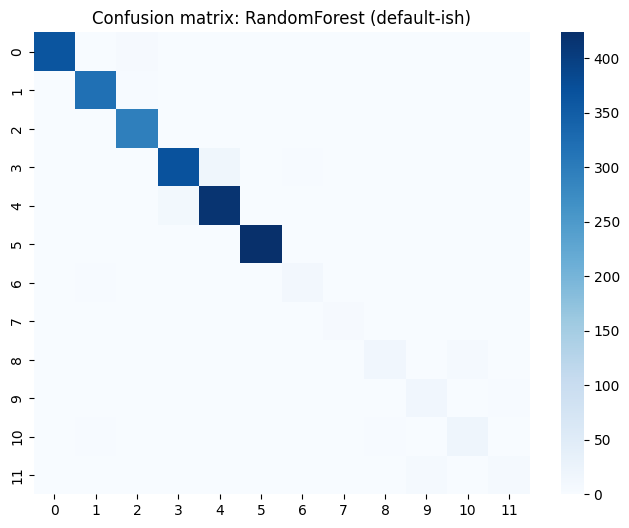

--- XGBoost (default-ish)
Accuracy: 0.9815529815529815
Macro F1: 0.8799354885456415
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       368
           1       1.00      1.00      1.00       322
           2       0.99      1.00      0.99       296
           3       0.99      0.97      0.98       388
           4       0.98      0.99      0.99       427
           5       1.00      1.00      1.00       424
           6       0.86      0.86      0.86        14
           7       0.75      0.86      0.80         7
           8       0.86      0.78      0.82        23
           9       0.71      0.67      0.69        18
          10       0.79      0.81      0.80        27
          11       0.65      0.65      0.65        17

    accuracy                           0.98      2331
   macro avg       0.88      0.88      0.88      2331
weighted avg       0.98      0.98      0.98      2331



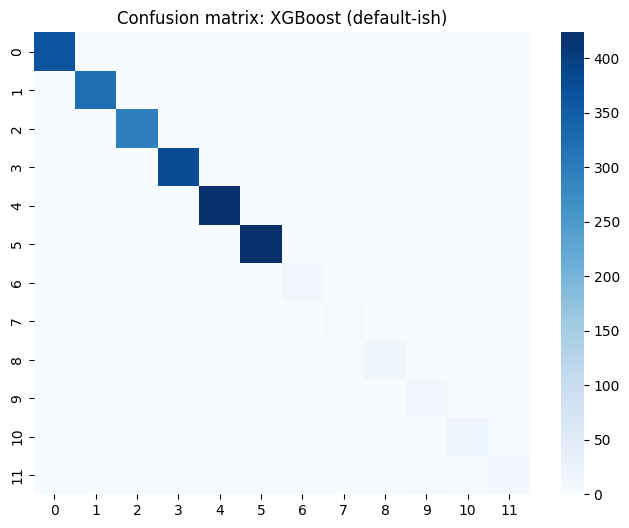

In [32]:
# RandomForest quick
y_train0 = (y_train - 1).astype(int)
y_test0  = (y_test - 1).astype(int) if y_test is not None else None

rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')
eval_model(rf, X_train, X_test, y_train0, y_test0, name='RandomForest (default-ish)')

# XGBoost quick - using sklearn API
n_classes = y_train0.nunique()
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=n_classes,
                            use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1, random_state=RANDOM_STATE)
eval_model(xgb_clf, X_train, X_test, y_train0, y_test0, name='XGBoost (default-ish)')

## 9) CatBoost (quick run and tuning template)
CatBoost often performs well out of the box and handles categorical features — here we have only numeric features so we use default settings. If CatBoost not installed, install with `pip install catboost`.

--- CatBoost (default-ish)
Accuracy: 0.9776919776919777
Macro F1: 0.8689596483486867
              precision    recall  f1-score   support

           1       0.99      1.00      1.00       368
           2       0.98      1.00      0.99       322
           3       1.00      0.99      1.00       296
           4       0.97      0.97      0.97       388
           5       0.98      0.98      0.98       427
           6       1.00      1.00      1.00       424
           7       0.91      0.71      0.80        14
           8       1.00      0.86      0.92         7
           9       0.89      0.70      0.78        23
          10       0.60      0.67      0.63        18
          11       0.74      0.85      0.79        27
          12       0.60      0.53      0.56        17

    accuracy                           0.98      2331
   macro avg       0.89      0.85      0.87      2331
weighted avg       0.98      0.98      0.98      2331



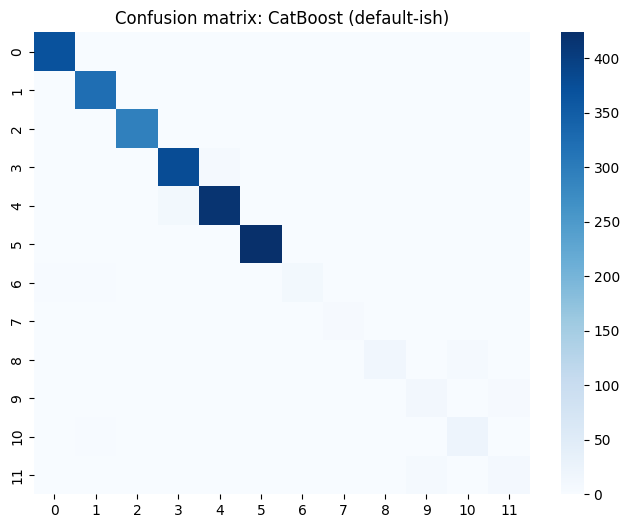

In [33]:
if CatBoostClassifier is None:
    print('CatBoost not installed. Install via `pip install catboost` to run this cell.')
else:
    cb = CatBoostClassifier(iterations=500, learning_rate=0.1, random_seed=RANDOM_STATE, verbose=0)
    eval_model(cb, X_train, X_test, y_train, y_test, name='CatBoost (default-ish)')

    # Tuning template (use RandomizedSearchCV or CatBoost's internal cv)
    # Example with sklearn RandomizedSearchCV wrapper (can be slow):
    # param_dist_cb = {
    #     'depth': [4,6,8,10],
    #     'learning_rate': [0.01, 0.05, 0.1],
    #     'iterations': [200, 500, 800]
    # }
    # rnd_cb = RandomizedSearchCV(CatBoostClassifier(random_seed=RANDOM_STATE, verbose=0),
    #                          param_distributions=param_dist_cb, n_iter=10, scoring='f1_macro', cv=StratifiedKFold(4), verbose=1)
    # rnd_cb.fit(X_train, y_train)
    # print('best params', rnd_cb.best_params_)
    # best_cb = rnd_cb.best_estimator_
    # eval_model(best_cb, X_train, X_test, y_train, y_test, name='CatBoost (tuned)')

## 10) KNN tuning (template)
KNN requires scaling. Use GridSearchCV for k and distance weights.

In [34]:
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_grid_knn = {
    'knn__n_neighbors': [3,5,7,9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean']
}
cv_knn = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
gs_knn = GridSearchCV(pipe_knn, param_grid_knn, scoring='f1_macro', cv=cv_knn, n_jobs=-1, verbose=1)

# NOTE: uncomment to run full grid search
# gs_knn.fit(X_train, y_train)
# print('best knn', gs_knn.best_params_, gs_knn.best_score_)
# best_knn = gs_knn.best_estimator_
# eval_model(best_knn, X_train, X_test, y_train, y_test, name='KNN (tuned)')

print('KNN tuning template ready. Uncomment the fit lines to run the search.')

KNN tuning template ready. Uncomment the fit lines to run the search.


## 11) Example hyperparameter tuning for RandomForest (RandomizedSearchCV)
Use StratifiedKFold and optimize macro-F1.
This cell is a template — reduce n_iter or param ranges to save time.

In [35]:
param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

rnd = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
                         param_distributions=param_dist, n_iter=12, scoring='f1_macro', cv=cv, verbose=1, random_state=RANDOM_STATE)

# NOTE: this can take time. Uncomment to run.
# rnd.fit(X_train, y_train)
# print('best params', rnd.best_params_)
# best_rf = rnd.best_estimator_
# eval_model(best_rf, X_train, X_test, y_train, y_test, name='RandomForest (tuned)')

print('RandomForest tuning template ready. Run the fit lines above when you want to tune.')

RandomForest tuning template ready. Run the fit lines above when you want to tune.


## 12) LightGBM quick run (optional)
Left here as a comparison if you want to try it; not required since you have CatBoost, XGBoost and RF.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140145
[LightGBM] [Info] Number of data points in the train set: 5436, number of used features: 561
[LightGBM] [Info] Start training from score -1.846195
[LightGBM] [Info] Start training from score -1.979393
[LightGBM] [Info] Start training from score -2.062659
[LightGBM] [Info] Start training from score -1.792864
[LightGBM] [Info] Start training from score -1.697052
[LightGBM] [Info] Start training from score -1.704104
[LightGBM] [Info] Start training from score -5.104291
[LightGBM] [Info] Start training from score -5.828210
[LightGBM] [Info] Start training from score -4.649555
[LightGBM] [Info] Start training from score -4.863129
[LightGBM] [Info] Start training from score -4.457664
[LightGBM] [Info] Start training from score -4.911919
[LightGBM] [Warning] No further splits with positive gain, be

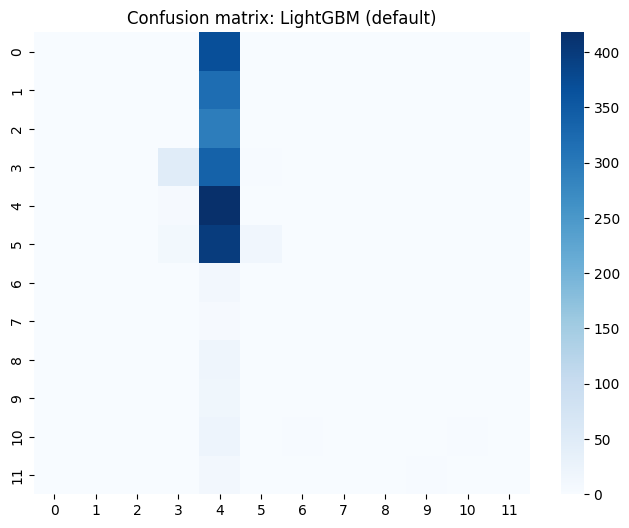

In [36]:
lgb_clf = lgb.LGBMClassifier(objective='multiclass', num_class=n_classes, random_state=RANDOM_STATE)
eval_model(lgb_clf, X_train, X_test, y_train, y_test, name='LightGBM (default)')

## 13) Additional method: simple 1D-CNN on features (optional)
If you prefer to keep experiments lighter, skip CNN. Kept here as optional.

In [37]:
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
except Exception as e:
    print('TensorFlow is not available in the environment:', e)
    tf = None

if tf is not None:
    # simple data reshape for Conv1D: (samples, features, 1)
    X_tr_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1)).astype('float32')
    X_te_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1)).astype('float32')
    y_tr_enc = tf.keras.utils.to_categorical(y_train - 1, num_classes=n_classes)  # labels 1..12 -> 0..11
    y_te_enc = tf.keras.utils.to_categorical(y_test - 1, num_classes=n_classes)

    def make_cnn(input_shape):
        inp = layers.Input(shape=input_shape)
        x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inp)
        x = layers.BatchNormalization()(x)
        x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dropout(0.4)(x)
        out = layers.Dense(n_classes, activation='softmax')(x)
        model = models.Model(inp, out)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    cnn = make_cnn((X_tr_cnn.shape[1], 1))
    cnn.summary()

    es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # NOTE: reduce epochs and batch_size for quick runs
    history = cnn.fit(X_tr_cnn, y_tr_enc, validation_split=0.15, epochs=30, batch_size=64, callbacks=[es])

    # evaluate
    y_pred_proba = cnn.predict(X_te_cnn)
    y_pred = np.argmax(y_pred_proba, axis=1) + 1
    print('CNN results')
    print('Accuracy', accuracy_score(y_test, y_pred))
    print('Macro F1', f1_score(y_test, y_pred, average='macro'))
    print(classification_report(y_test, y_pred, zero_division=0))
else:
    print('TensorFlow not installed — skip CNN cell or install TF.')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 561, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 561, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 561, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 561, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,764 (104.55 KB)

 Trainable params: 26,636 (104.05 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3355 - loss: 1.6123 - val_accuracy: 0.4914 - val_loss: 2.2236
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3747 - loss: 1.3641 - val_accuracy: 0.3015 - val_loss: 2.2156
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4006 - loss: 1.2884 - val_accuracy: 0.3652 - val_loss: 2.0707
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4106 - loss: 1.2595 - val_accuracy: 0.3958 - val_loss: 1.9230
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4240 - loss: 1.2344 - val_accuracy: 0.4326 - val_loss: 1.7876
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4383 - loss: 1.2090 - val_accuracy: 0.4792 - val_loss: 1.4533
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4543 - loss: 1.1932 - val_accuracy: 0.4988 - val_loss: 1.3116
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4677 - loss: 1.1717 - val_accuracy: 0.4804 - v

## 14) SHAP and interpretation (template)
Compute SHAP for tree models (RandomForest/XGBoost/CatBoost) to explain model behavior for classes and investigate feature importance for confusion cases.
Be careful: SHAP can be slow on large feature sets or many samples. Use a sample subset.

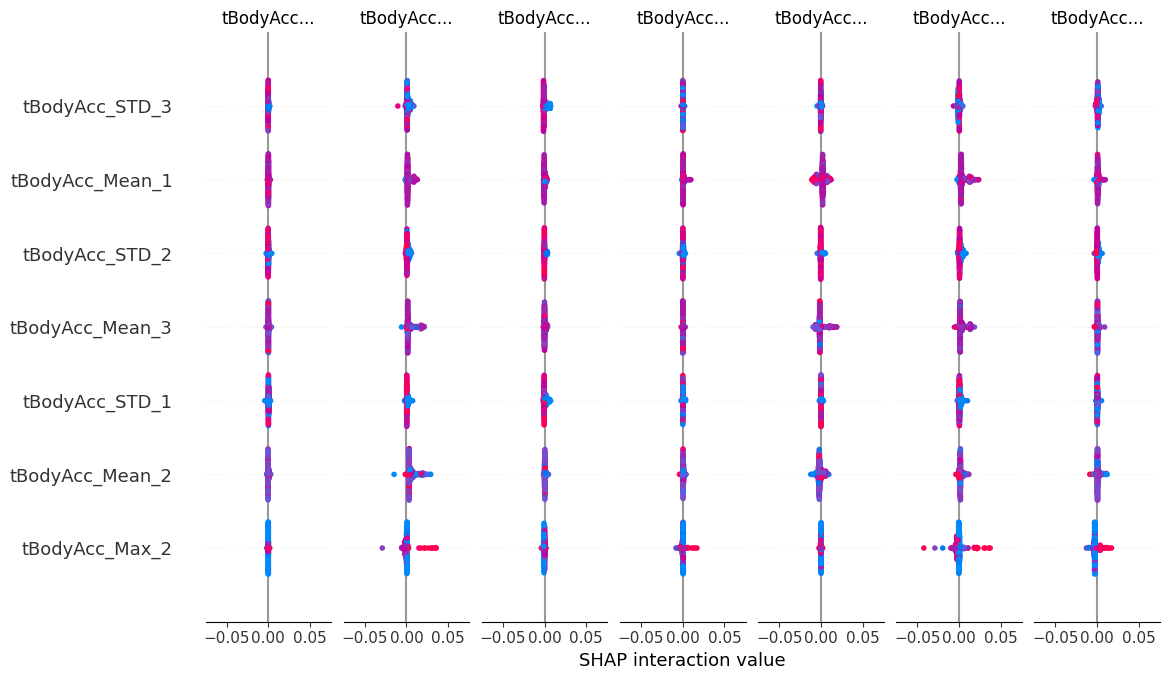

In [38]:
try:
    import shap
except Exception as e:
    print('shap not available:', e)
    shap = None

# Use the best model from tuning above if available, else the quick rf/xgb/cb we trained
model_for_shap = None
if 'best_rf' in globals():
    model_for_shap = globals()['best_rf']
elif 'rf' in globals():
    model_for_shap = rf
elif 'xgb_clf' in globals():
    model_for_shap = xgb_clf
elif 'cb' in globals() and CatBoostClassifier is not None:
    model_for_shap = cb

if shap is not None and model_for_shap is not None:
    # take a small sample to speed up
    sample_idx = np.random.choice(X_test.shape[0], min(300, X_test.shape[0]), replace=False)
    Xshap = X_test.iloc[sample_idx]

    if hasattr(shap, 'TreeExplainer'):
        explainer = shap.TreeExplainer(model_for_shap)
        shap_values = explainer.shap_values(Xshap)
        # summary_plot for multiclass will show one row per class
        try:
            shap.summary_plot(shap_values, Xshap)
        except Exception as e:
            print('plotting error:', e)
    else:
        print('No TreeExplainer available; consider KernelExplainer (slower).')
else:
    print('SHAP or a model for SHAP is not available. Install shap and/or run model training above.')

## 15) Ablation experiments (examples / templates)
Below are templates for the non-trivial research questions in the assignment. Run each block to compare settings.

In [39]:
# A) Time-domain vs Frequency-domain vs Combined
time_cols = [c for c in X.columns if c.startswith('t')]
freq_cols = [c for c in X.columns if c.startswith('f')]
print('time_cols:', len(time_cols), 'freq_cols:', len(freq_cols))

def train_and_report(cols, name):
    Xt = X_train[cols]
    Xv = X_test[cols]
    rf_tmp = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')
    rf_tmp.fit(Xt, y_train)
    ypred = rf_tmp.predict(Xv)
    print('\n--', name)
    print('Macro F1', f1_score(y_test, ypred, average='macro'))
    return rf_tmp

rf_time = None
rf_freq = None
if len(time_cols) > 0:
    rf_time = train_and_report(time_cols, 'RandomForest on TIME features')
if len(freq_cols) > 0:
    rf_freq = train_and_report(freq_cols, 'RandomForest on FREQ features')
if len(time_cols) > 0 and len(freq_cols) > 0:
    rf_both = train_and_report(time_cols + freq_cols, 'RandomForest on COMBINED features')

time_cols: 272 freq_cols: 289

-- RandomForest on TIME features
Macro F1 0.8652331497867883

-- RandomForest on FREQ features
Macro F1 0.7148826837226557

-- RandomForest on COMBINED features
Macro F1 0.8776588077559224


## 16) Save models / results (examples)
Save your best models and experiment results for the report.

In [40]:
""" import joblib

os.makedirs('models', exist_ok=True)
# Example: save rf if exists
if 'best_rf' in globals():
    joblib.dump(best_rf, 'models/best_rf.joblib')
    print('saved best_rf')
elif 'rf' in globals():
    joblib.dump(rf, 'models/rf_quick.joblib')
    print('saved rf_quick')

if 'cb' in globals() and CatBoostClassifier is not None:
    joblib.dump(cb, 'models/catboost_quick.joblib')
    print('saved catboost_quick')

print('done') """

" import joblib\n\nos.makedirs('models', exist_ok=True)\n# Example: save rf if exists\nif 'best_rf' in globals():\n    joblib.dump(best_rf, 'models/best_rf.joblib')\n    print('saved best_rf')\nelif 'rf' in globals():\n    joblib.dump(rf, 'models/rf_quick.joblib')\n    print('saved rf_quick')\n\nif 'cb' in globals() and CatBoostClassifier is not None:\n    joblib.dump(cb, 'models/catboost_quick.joblib')\n    print('saved catboost_quick')\n\nprint('done') "

## 17) Notes for the report
 - Include method descriptions and key hyperparameters tuned.
 - Present results (tables + confusion matrices) for all methods.
 - Answer at least two non-trivial questions (e.g., time vs frequency, accelerometer vs gyroscope contributions, ablation feature selection).
 - Use SHAP / feature importance to explain model decisions and show examples of misclassifications.
 - Add an explicit contributions section listing who implemented which notebook sections, experiments, and report parts.


## Final: Next steps (suggested)
1. Run model tuning for RF, XGBoost and CatBoost (use RandomizedSearchCV or CatBoost's own cv).
2. Run KNN grid search for best k and distance options.
3. Perform ablation experiments and SHAP analysis.
4. Fill the report sections and clearly state contributions.

If you want, I can generate a ready-to-run notebook with some moderate tuning ranges and tuned parameters filled in (this will still take time to run). Do you want me to prepare a version with tuning lines activated and moderate n_iter / param grids?